# CS 510 Project
This Python script was written by Cassidy Buhler cb3452@drexel.edu  
Fish data was obtained by Shraman Kadapa sk3496@drexel.edu using COMSOL and Matlab


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import math
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import metrics

## Importing Data

In [3]:
## setting seeds to ensure producibility of results
os.environ['PYTHONHASHSEED']='0'
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

In [4]:
path = "/content/gdrive/My Drive/CS510/project-github/"  #cassie's path to the file -- won't be the same on your machine
df = pd.read_excel(path+'data/fishdata.xlsx',index_col = 0)#read in data
df = df[['Frequency(hz)','Distance b/w fins','Lateral(N)','Thrust(N)','Phase difference(degrees)']] #reording the columns so target features are the last 2
df['Phase difference(degrees)'] =np.deg2rad(df['Phase difference(degrees)']) #convert to radians before scaling - not sure why but it performs better than if kept in degrees
df.rename(columns = {'Frequency(hz)':'Frequency','Thrust(N)':'Thrust', 'Distance b/w fins':'Distance','Lateral(N)': 'Lateral Force','Phase difference(degrees)':'Phase Difference'},inplace = True) #renaming columns to shorten

## Visualizing Dataset

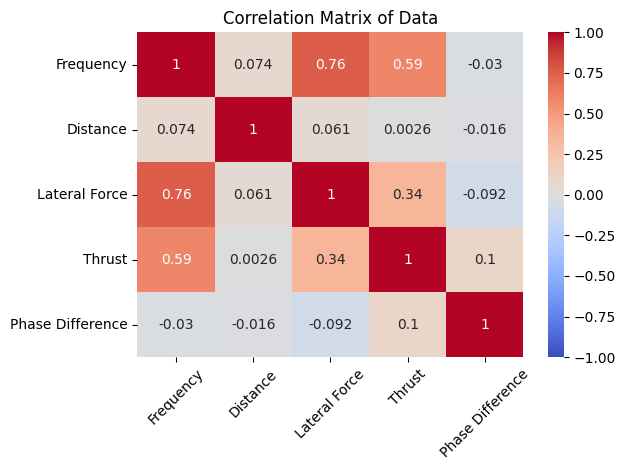

In [5]:
sns.heatmap(df.corr(),annot=True,vmin=-1, vmax=1, center= 0, cmap= 'coolwarm') #visualizing data
plt.xticks(rotation=45)
plt.title("Correlation Matrix of Data")
plt.tight_layout()
plt.savefig(path+'figures/corr_mat.png')
plt.show()

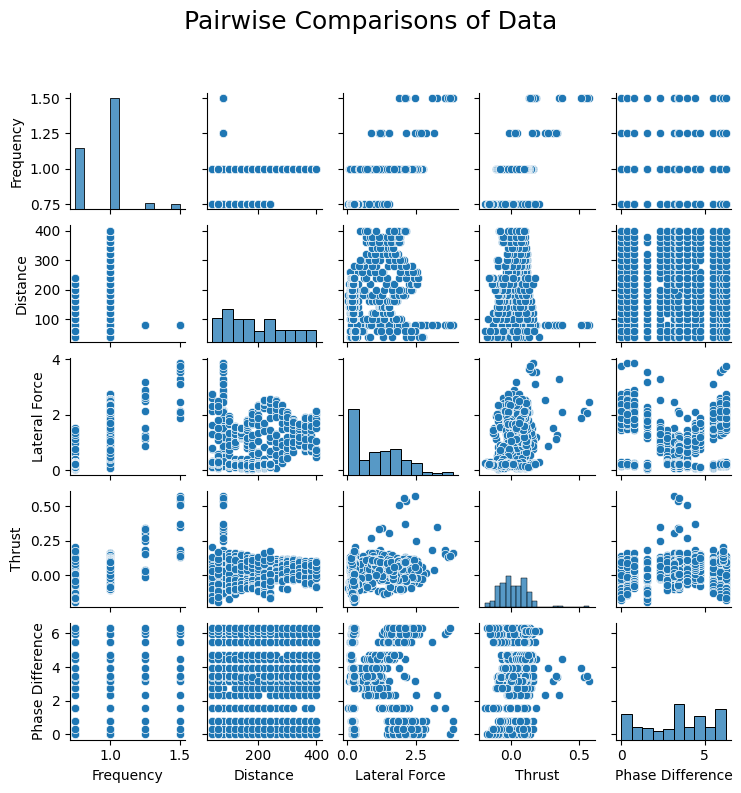

In [6]:
f = sns.pairplot(df,height = 1.5)
f.fig.suptitle("Pairwise Comparisons of Data",fontsize = 18, y = 1.05)
f.tight_layout()
f.savefig(path+'figures/pairplot.png')
plt.show()

## Prepping data for training

In [7]:
def splitData(df): #80/10/10 data split
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=0,shuffle = True) # split data into test and train
  Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size =0.11, random_state=0,shuffle = True) #split training again to get the validation set
  scaler = MinMaxScaler(feature_range=(-1,1))
  scaler.fit(Xtrain)   #standardizing features based on training data
  Xtrain = scaler.transform(Xtrain)
  Xval = scaler.transform(Xval)
  Xtest = scaler.transform(Xtest)
  scaler_target =  MinMaxScaler(feature_range=(-1,1))
  scaler_target.fit(ytrain)
  ytrain = scaler_target.transform(ytrain)
  yval = scaler_target.transform(yval)
  ytest = scaler_target.transform(ytest)
  return Xtrain, ytrain, Xval, yval, Xtest, ytest, scaler_target


In [8]:
xcols = ['Frequency','Distance','Lateral Force'] #features
ycols = ['Thrust','Phase Difference'] #target data
X = df[xcols] #feature matrix
y = df[ycols] #target matrix
Xtrain, ytrain, Xval, yval, Xtest, ytest, scaler_target = splitData(df) #splitting data into 3 groups: train, validation, and test

## Neural Networks

In [9]:
def plotProgress(history,num): #plotting the training progress on validation and training data
  plt.plot(history.history['loss']) # plotting MSE (loss)
  plt.plot(history.history['val_loss'])
  plt.title('NN'+str(num)+': Loss (MSE)')
  plt.ylabel('MSE')
  plt.xlabel('Epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.tight_layout()
  plt.savefig(path+'figures/MSE'+str(num)+'.png')
  plt.show()
  return


def getResults(model,Xtest,ytest,scaler_target, num):
  results = model.evaluate(Xtest,ytest)
  ypred = model.predict(Xtest, verbose=0) #predict output on test data
  ytest, ypred = unscaleData(ytest,ypred,scaler_target)
  graphPredictions(ypred,ytest,num)
  print("Model MSE:%.4f" % keras.losses.mean_squared_error(ytest.flatten(), ypred.flatten()))
  print("Thrust MSE:%.4f" % keras.losses.mean_squared_error(ytest[:,0], ypred[:,0]))
  print("Phase Difference MSE:%.4f" % keras.losses.mean_squared_error(ytest[:,1], ypred[:,1]))
  return

def unscaleData(ytest,ypred,scaler_target): #we reverting back to original scaling for target data to get a better idea of model accuracy
  ytest = scaler_target.inverse_transform(ytest)
  ypred = scaler_target.inverse_transform(ypred)
  return ytest, ypred

def graphPredictions(ypred,ytest,num): #graphing predictions from network
  a = plt.axes(aspect='equal')
  lims = [min(min(ypred[:,0]),min(ytest[:,0])), max(max(ypred[:,0]),max(ytest[:,0]))]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims,'k--',label = 'perfect fit')
  m, b = np.polyfit(ytest[:,0], ypred[:,0], 1)
  xvals = np.sort(np.append(ytest[:,0], max(max(ypred[:,0]),max(ytest[:,0]))))
  plt.plot(xvals, m*xvals + b,'k-',label = 'actual fit')
  plt.plot(ytest[:,0],ypred[:,0],'b.',label = 'thrust')
  plt.xlabel('True Thrust (N)')
  plt.ylabel('Predicted Thrust (N)')
  plt.title('NN' +str(num) + ': Thrust Prediction Accuracy')
  plt.legend()
  plt.tight_layout()
  plt.savefig(path+'figures/predictionThrust'+str(num)+'.png')
  plt.show()

  a = plt.axes(aspect='equal')
  lims = [min(min(ypred[:,1]),min(ytest[:,1])), max(max(ypred[:,1]),max(ytest[:,1]))]
  plt.xlim(lims)
  plt.ylim(lims)
  plt.plot(lims, lims,'k--',label = 'perfect fit')
  m, b = np.polyfit(ytest[:,1], ypred[:,1], 1)
  xvals = np.sort(ytest[:,1])
  plt.plot(xvals, m*xvals + b,'k-',label = 'actual fit')
  plt.plot(ytest[:,1],ypred[:,1],'r.',label = 'phase difference')
  plt.legend()
  plt.xlabel('True Phase Difference (radians)')
  plt.ylabel('Predicted Phase Difference (radians)')
  plt.title('NN' +str(num) + ': Phase Difference Prediction Accuracy')
  plt.tight_layout()
  plt.savefig(path+'figures/predictionPhaseDiff'+str(num)+'.png')
  plt.show()
  return



## Neural Network #1

Epoch 1/500
23/23 - 3s - loss: 0.3070 - mae: 0.4454 - val_loss: 0.3263 - val_mae: 0.4796 - 3s/epoch - 119ms/step
Epoch 2/500
23/23 - 0s - loss: 0.2842 - mae: 0.4210 - val_loss: 0.3066 - val_mae: 0.4551 - 137ms/epoch - 6ms/step
Epoch 3/500
23/23 - 0s - loss: 0.2683 - mae: 0.4032 - val_loss: 0.2924 - val_mae: 0.4358 - 154ms/epoch - 7ms/step
Epoch 4/500
23/23 - 0s - loss: 0.2573 - mae: 0.3905 - val_loss: 0.2829 - val_mae: 0.4218 - 154ms/epoch - 7ms/step
Epoch 5/500
23/23 - 0s - loss: 0.2501 - mae: 0.3814 - val_loss: 0.2761 - val_mae: 0.4131 - 142ms/epoch - 6ms/step
Epoch 6/500
23/23 - 0s - loss: 0.2448 - mae: 0.3757 - val_loss: 0.2717 - val_mae: 0.4076 - 145ms/epoch - 6ms/step
Epoch 7/500
23/23 - 0s - loss: 0.2412 - mae: 0.3719 - val_loss: 0.2685 - val_mae: 0.4037 - 122ms/epoch - 5ms/step
Epoch 8/500
23/23 - 0s - loss: 0.2386 - mae: 0.3691 - val_loss: 0.2657 - val_mae: 0.4008 - 160ms/epoch - 7ms/step
Epoch 9/500
23/23 - 0s - loss: 0.2362 - mae: 0.3670 - val_loss: 0.2638 - val_mae: 0.3989 

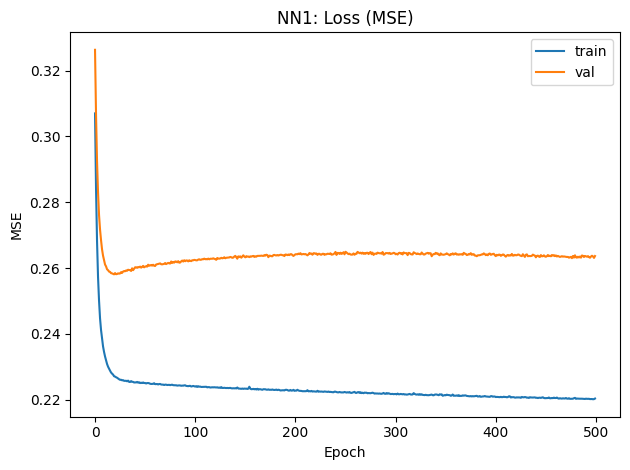

2/2 [==============================] - 0s 10ms/step - loss: 0.1641 - mae: 0.2799


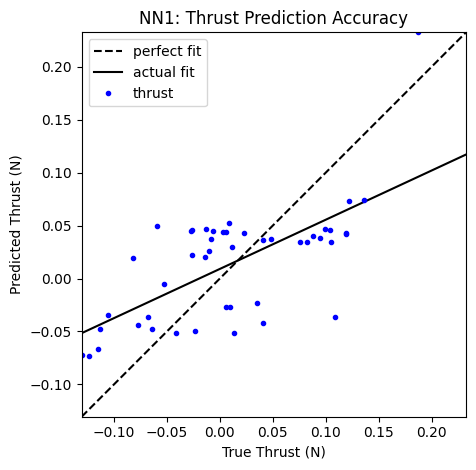

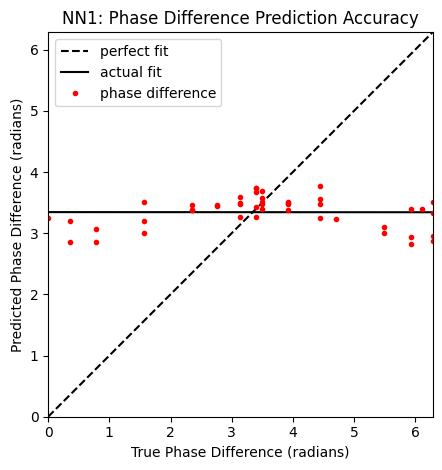

Model MSE:1.5050
Thrust MSE:0.0033
Phase Difference MSE:3.0066


In [10]:
def NN1(Xtrain,Xval,ytrain,yval,path,num):
  n_input = Xtrain.shape[1] # this will be 3 since we have 3 input features
  n_output = ytrain.shape[1] # this will be 2 since we have 2 output features
  model = keras.Sequential()
  model.add(keras.layers.Input(shape = (n_input,),name = 'Input_Layer'))
  model.add(keras.layers.Dense(20, activation="elu",name = 'Layer_1'))
  model.add(keras.layers.Dense(20, activation="elu",name = 'Layer_2'))
  model.add(keras.layers.Dense(10, activation="elu",name = 'Layer_3'))
  model.add(keras.layers.Dense(n_output, activation = 'linear', name = 'Output_Layer'))
  metrics = ['mae']
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.mean_squared_error, metrics=metrics)
  history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=500, verbose=2,batch_size=16) #get model training results

  model.summary()
  plotProgress(history,num) #plot progress
  keras.utils.plot_model(model, path+'figures/NN'+str(num)+'.png', show_shapes=True) #save model
  return model

model1 = NN1(Xtrain,Xval,ytrain,yval,path,1) #calling model
getResults(model1,Xtest,ytest,scaler_target,1) #getting prediction metrics

## Neural Network #2

Epoch 1/500
23/23 - 2s - loss: 0.8452 - mae: 0.7270 - val_loss: 0.3973 - val_mae: 0.4690 - 2s/epoch - 66ms/step
Epoch 2/500
23/23 - 0s - loss: 0.8282 - mae: 0.7218 - val_loss: 0.3733 - val_mae: 0.4550 - 137ms/epoch - 6ms/step
Epoch 3/500
23/23 - 0s - loss: 0.7377 - mae: 0.6781 - val_loss: 0.3542 - val_mae: 0.4436 - 109ms/epoch - 5ms/step
Epoch 4/500
23/23 - 0s - loss: 0.7199 - mae: 0.6785 - val_loss: 0.3377 - val_mae: 0.4332 - 122ms/epoch - 5ms/step
Epoch 5/500
23/23 - 0s - loss: 0.6878 - mae: 0.6514 - val_loss: 0.3250 - val_mae: 0.4238 - 111ms/epoch - 5ms/step
Epoch 6/500
23/23 - 0s - loss: 0.6269 - mae: 0.6214 - val_loss: 0.3155 - val_mae: 0.4148 - 150ms/epoch - 7ms/step
Epoch 7/500
23/23 - 0s - loss: 0.5698 - mae: 0.5938 - val_loss: 0.3075 - val_mae: 0.4094 - 129ms/epoch - 6ms/step
Epoch 8/500
23/23 - 0s - loss: 0.5012 - mae: 0.5568 - val_loss: 0.3021 - val_mae: 0.4045 - 133ms/epoch - 6ms/step
Epoch 9/500
23/23 - 0s - loss: 0.5043 - mae: 0.5682 - val_loss: 0.2988 - val_mae: 0.4008 -

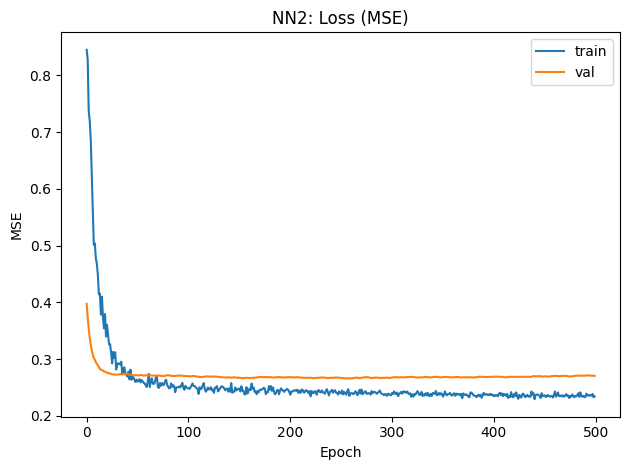

2/2 [==============================] - 0s 9ms/step - loss: 0.1666 - mae: 0.2866


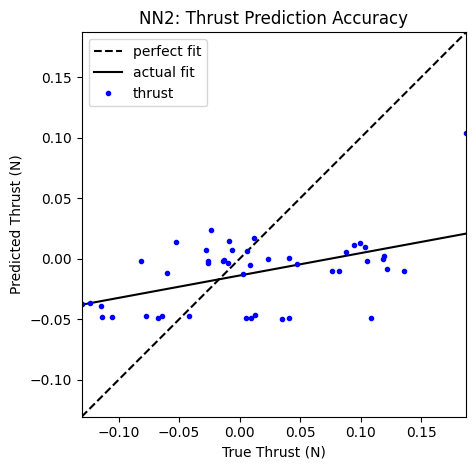

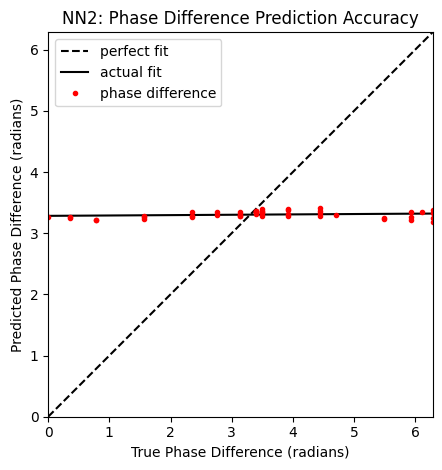

Model MSE:1.4676
Thrust MSE:0.0051
Phase Difference MSE:2.9300


In [11]:
def NN2(Xtrain,Xval,ytrain,yval,path,num):
  n_input = Xtrain.shape[1] # this will be 3 since we have 3 input features
  n_output = ytrain.shape[1] # this will be 2 since we have 2 output features
  model = keras.Sequential()
  model.add(keras.Input(shape = (n_input,),name = 'Input_Layer'))
  model.add(keras.layers.Dense(50, activation="elu",name = 'Layer_1'))
  model.add(keras.layers.AlphaDropout(0.25, name = 'Dropout'))
  model.add(keras.layers.Dense(40, activation="elu",name = 'Layer_2'))
  model.add(keras.layers.Dense(30, activation="elu",name = 'Layer_3'))
  model.add(keras.layers.Dense(n_output, activation = 'linear', name = 'Output_Layer'))
  metrics = ['mae']  # want to look at mean absolute error + MSE while training data
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.mean_squared_error, metrics=metrics)
  history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=500, verbose=2,batch_size = 16) #get model training results
  model.summary()
  plotProgress(history,num) #plot progress
  keras.utils.plot_model(model, path+'figures/NN'+str(num)+'.png', show_shapes=True) #save model
  return model

model2 = NN2(Xtrain,Xval,ytrain,yval,path,2) #calling model
getResults(model2,Xtest,ytest,scaler_target,2)

Epoch 1/500
23/23 - 1s - loss: 0.3947 - mae: 0.5066 - val_loss: 0.4267 - val_mae: 0.5333 - 1s/epoch - 44ms/step
Epoch 2/500
23/23 - 0s - loss: 0.3844 - mae: 0.4982 - val_loss: 0.4164 - val_mae: 0.5251 - 85ms/epoch - 4ms/step
Epoch 3/500
23/23 - 0s - loss: 0.3747 - mae: 0.4901 - val_loss: 0.4064 - val_mae: 0.5172 - 77ms/epoch - 3ms/step
Epoch 4/500
23/23 - 0s - loss: 0.3656 - mae: 0.4824 - val_loss: 0.3971 - val_mae: 0.5093 - 72ms/epoch - 3ms/step
Epoch 5/500
23/23 - 0s - loss: 0.3571 - mae: 0.4752 - val_loss: 0.3882 - val_mae: 0.5020 - 88ms/epoch - 4ms/step
Epoch 6/500
23/23 - 0s - loss: 0.3490 - mae: 0.4682 - val_loss: 0.3800 - val_mae: 0.4947 - 88ms/epoch - 4ms/step
Epoch 7/500
23/23 - 0s - loss: 0.3416 - mae: 0.4616 - val_loss: 0.3724 - val_mae: 0.4880 - 72ms/epoch - 3ms/step
Epoch 8/500
23/23 - 0s - loss: 0.3346 - mae: 0.4556 - val_loss: 0.3651 - val_mae: 0.4818 - 85ms/epoch - 4ms/step
Epoch 9/500
23/23 - 0s - loss: 0.3279 - mae: 0.4494 - val_loss: 0.3584 - val_mae: 0.4757 - 69ms/e

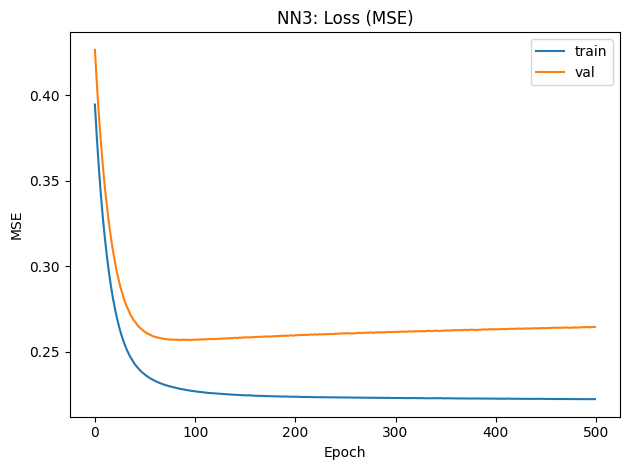

2/2 [==============================] - 0s 11ms/step - loss: 0.1643 - mae: 0.2817


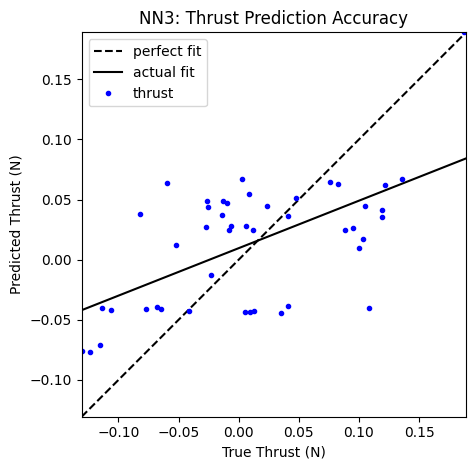

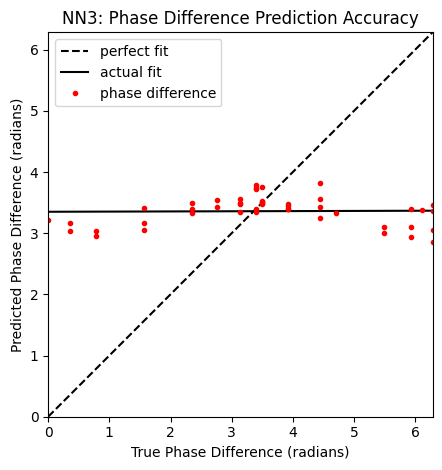

Model MSE:1.4879
Thrust MSE:0.0039
Phase Difference MSE:2.9719


In [12]:
def NN3(Xtrain,Xval,ytrain,yval,path,num):
  n_input = Xtrain.shape[1] # this will be 3 since we have 3 input features
  n_output = ytrain.shape[1] # this will be 2 since we have 2 output features
  model = keras.Sequential()
  model.add(keras.Input(shape = (n_input,),name = 'Input_Layer'))
  model.add(keras.layers.Dense(40, activation="elu",name = 'Layer_1'))
  model.add(keras.layers.Dense(20, activation="elu",name = 'Layer_2'))
  model.add(keras.layers.Dense(10, activation="elu",name = 'Layer_3'))
  model.add(keras.layers.Dense(n_output, activation = 'linear', name = 'Output_Layer'))
  metrics = ['mae']  # want to look at mean absolute error + MSE while training data
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000025), loss=keras.losses.mean_squared_error, metrics=metrics)
  history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=500, verbose=2,batch_size = 16) #get model training results
  model.summary()

  plotProgress(history,num) #plot progress
  keras.utils.plot_model(model, path+'figures/NN'+str(num)+'.png', show_shapes=True) #save model
  return model

model3 = NN3(Xtrain,Xval,ytrain,yval,path,3) #calling model
getResults(model3,Xtest,ytest,scaler_target,3)